In [23]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 

import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping
import time

# Load Data

In [2]:
train = pd.read_csv("./bikeshare/bikeshare_train.csv").drop("Unnamed: 0", axis=1)
train

,time,year,month,hour,station_id,events,Rush_hour,isWeekdays,city_zip_94063.0,city_zip_94107.0,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,association_station,bikes_available_percentage
0,2013/08/29,2013,8.0,13,2.0,0,0,1,0,0,...,10.0,10.0,16.0,7.0,24.0,0.0,4.0,320.0,0.074074,0.099930
1,2013/08/29,2013,8.0,14,2.0,0,0,1,0,0,...,10.0,10.0,16.0,7.0,24.0,0.0,4.0,320.0,0.099930,0.074074
2,2013/08/29,2013,8.0,15,2.0,0,0,1,0,0,...,10.0,10.0,16.0,7.0,24.0,0.0,4.0,320.0,0.074074,0.074074
3,2013/08/29,2013,8.0,16,2.0,0,1,1,0,0,...,10.0,10.0,16.0,7.0,24.0,0.0,4.0,320.0,0.074074,0.074074
4,2013/08/29,2013,8.0,17,2.0,0,1,1,0,0,...,10.0,10.0,16.0,7.0,24.0,0.0,4.0,320.0,0.074074,0.107682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050538,2015/05/31,2015,5.0,19,84.0,0,0,0,0,0,...,10.0,7.0,17.0,7.0,22.0,0.0,6.0,311.0,0.388683,0.466667
1050539,2015/05/31,2015,5.0,20,84.0,0,0,0,0,0,...,10.0,7.0,17.0,7.0,22.0,0.0,6.0,311.0,0.394033,0.466667
1050540,2015/05/31,2015,5.0,21,84.0,0,0,0,0,0,...,10.0,7.0,17.0,7.0,22.0,0.0,6.0,311.0,0.391975,0.466667
1050541,2015/05/31,2015,5.0,22,84.0,0,0,0,0,0,...,10.0,7.0,17.0,7.0,22.0,0.0,6.0,311.0,0.391923,0.466667


In [3]:
test = pd.read_csv("./bikeshare/bikeshare_test.csv").drop("Unnamed: 0", axis=1)
test

,time,year,month,hour,station_id,events,Rush_hour,isWeekdays,city_zip_94063.0,city_zip_94107.0,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,association_station,bikes_available_percentage
0,2015/06/01,2015,6.0,0,2.0,0,0,1,0,0,...,10.0,10.0,18.0,10.0,23.0,0.0,5.0,320.0,0.392181,0.503086
1,2015/06/01,2015,6.0,1,2.0,0,0,1,0,0,...,10.0,10.0,18.0,10.0,23.0,0.0,5.0,320.0,0.389918,0.493827
2,2015/06/01,2015,6.0,2,2.0,0,0,1,0,0,...,10.0,10.0,18.0,10.0,23.0,0.0,5.0,320.0,0.386831,0.506173
3,2015/06/01,2015,6.0,3,2.0,0,0,1,0,0,...,10.0,10.0,18.0,10.0,23.0,0.0,5.0,320.0,0.390947,0.502469
4,2015/06/01,2015,6.0,4,2.0,0,0,1,0,0,...,10.0,10.0,18.0,10.0,23.0,0.0,5.0,320.0,0.389712,0.503086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154216,2015/08/31,2015,8.0,19,84.0,0,0,1,0,0,...,10.0,10.0,20.0,6.0,24.0,0.0,1.0,308.0,0.572469,0.533333
154217,2015/08/31,2015,8.0,20,84.0,0,0,1,0,0,...,10.0,10.0,20.0,6.0,24.0,0.0,1.0,308.0,0.554321,0.533333
154218,2015/08/31,2015,8.0,21,84.0,0,0,1,0,0,...,10.0,10.0,20.0,6.0,24.0,0.0,1.0,308.0,0.555556,0.533333
154219,2015/08/31,2015,8.0,22,84.0,0,0,1,0,0,...,10.0,10.0,20.0,6.0,24.0,0.0,1.0,308.0,0.555556,0.533333


In [4]:
train.columns

Index(['time', 'year', 'month', 'hour', 'station_id', 'events', 'Rush_hour',
       'isWeekdays', 'city_zip_94063.0', 'city_zip_94107.0',
       'city_zip_94301.0', 'city_zip_95113.0', 'month_2.0', 'month_3.0',
       'month_4.0', 'month_5.0', 'month_6.0', 'month_7.0', 'month_8.0',
       'month_9.0', 'month_10.0', 'month_11.0', 'month_12.0',
       'bikes_available', 'docks_available', 'dock_count', 'max_temperature_f',
       'mean_temperature_f', 'min_temperature_f', 'max_dew_point_f',
       'mean_dew_point_f', 'min_dew_point_f', 'max_humidity', 'mean_humidity',
       'min_humidity', 'max_sea_level_pressure_inches',
       'mean_sea_level_pressure_inches', 'min_sea_level_pressure_inches',
       'max_visibility_miles', 'mean_visibility_miles', 'min_visibility_miles',
       'max_wind_Speed_mph', 'mean_wind_speed_mph', 'max_gust_speed_mph',
       'precipitation_inches', 'cloud_cover', 'wind_dir_degrees',
       'association_station', 'bikes_available_percentage'],
      dtype='obj

In [5]:
train.dtypes

time                               object
year                                int64
month                             float64
hour                                int64
station_id                        float64
events                              int64
Rush_hour                           int64
isWeekdays                          int64
city_zip_94063.0                    int64
city_zip_94107.0                    int64
city_zip_94301.0                    int64
city_zip_95113.0                    int64
month_2.0                           int64
month_3.0                           int64
month_4.0                           int64
month_5.0                           int64
month_6.0                           int64
month_7.0                           int64
month_8.0                           int64
month_9.0                           int64
month_10.0                          int64
month_11.0                          int64
month_12.0                          int64
bikes_available                   

# Standardization

In [6]:
train.columns[23]

'bikes_available'

In [7]:
train.columns[-1]

'bikes_available_percentage'

In [8]:
y_stdscaler = StandardScaler()
y_stdscaler.fit(train.iloc[:, -1:])

StandardScaler()

In [9]:
y_stdscaler.transform(train.iloc[:, -1:])

array([[-2.00705653],
       [-2.14472606],
       [-2.14472606],
       ...,
       [-0.05438159],
       [-0.05438159],
       [-0.05438159]])

In [10]:
stdscaler = StandardScaler()
stdscaler.fit(train.iloc[:, 23:])
train.iloc[:, 23:] = stdscaler.transform(train.iloc[:, 23:])
test.iloc[:, 23:] = stdscaler.transform(test.iloc[:, 23:])
train

,time,year,month,hour,station_id,events,Rush_hour,isWeekdays,city_zip_94063.0,city_zip_94107.0,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,association_station,bikes_available_percentage
0,2013/08/29,2013,8.0,13,2.0,0,0,1,0,0,...,0.295534,0.667157,-0.178245,0.102675,0.124231,-0.175942,0.338836,0.712189,-4.420412,-2.007057
1,2013/08/29,2013,8.0,14,2.0,0,0,1,0,0,...,0.295534,0.667157,-0.178245,0.102675,0.124231,-0.175942,0.338836,0.712189,-4.141651,-2.144726
2,2013/08/29,2013,8.0,15,2.0,0,0,1,0,0,...,0.295534,0.667157,-0.178245,0.102675,0.124231,-0.175942,0.338836,0.712189,-4.420412,-2.144726
3,2013/08/29,2013,8.0,16,2.0,0,1,1,0,0,...,0.295534,0.667157,-0.178245,0.102675,0.124231,-0.175942,0.338836,0.712189,-4.420412,-2.144726
4,2013/08/29,2013,8.0,17,2.0,0,1,1,0,0,...,0.295534,0.667157,-0.178245,0.102675,0.124231,-0.175942,0.338836,0.712189,-4.420412,-1.965783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050538,2015/05/31,2015,5.0,19,84.0,0,0,0,0,0,...,0.295534,-0.354110,-0.032682,0.102675,-0.109268,-0.175942,1.196055,0.608925,-1.028533,-0.054382
1050539,2015/05/31,2015,5.0,20,84.0,0,0,0,0,0,...,0.295534,-0.354110,-0.032682,0.102675,-0.109268,-0.175942,1.196055,0.608925,-0.970856,-0.054382
1050540,2015/05/31,2015,5.0,21,84.0,0,0,0,0,0,...,0.295534,-0.354110,-0.032682,0.102675,-0.109268,-0.175942,1.196055,0.608925,-0.993039,-0.054382
1050541,2015/05/31,2015,5.0,22,84.0,0,0,0,0,0,...,0.295534,-0.354110,-0.032682,0.102675,-0.109268,-0.175942,1.196055,0.608925,-0.993603,-0.054382


In [11]:
test

,time,year,month,hour,station_id,events,Rush_hour,isWeekdays,city_zip_94063.0,city_zip_94107.0,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,association_station,bikes_available_percentage
0,2015/06/01,2015,6.0,0,2.0,0,0,1,0,0,...,0.295534,0.667157,0.112882,0.933860,0.007482,-0.175942,0.767446,0.712189,-0.990821,0.139534
1,2015/06/01,2015,6.0,1,2.0,0,0,1,0,0,...,0.295534,0.667157,0.112882,0.933860,0.007482,-0.175942,0.767446,0.712189,-1.015223,0.090233
2,2015/06/01,2015,6.0,2,2.0,0,0,1,0,0,...,0.295534,0.667157,0.112882,0.933860,0.007482,-0.175942,0.767446,0.712189,-1.048498,0.155968
3,2015/06/01,2015,6.0,3,2.0,0,0,1,0,0,...,0.295534,0.667157,0.112882,0.933860,0.007482,-0.175942,0.767446,0.712189,-1.004131,0.136247
4,2015/06/01,2015,6.0,4,2.0,0,0,1,0,0,...,0.295534,0.667157,0.112882,0.933860,0.007482,-0.175942,0.767446,0.712189,-1.017441,0.139534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154216,2015/08/31,2015,8.0,19,84.0,0,0,1,0,0,...,0.295534,0.667157,0.404009,-0.174386,0.124231,-0.175942,-0.946993,0.574504,0.952910,0.300583
154217,2015/08/31,2015,8.0,20,84.0,0,0,1,0,0,...,0.295534,0.667157,0.404009,-0.174386,0.124231,-0.175942,-0.946993,0.574504,0.757250,0.300583
154218,2015/08/31,2015,8.0,21,84.0,0,0,1,0,0,...,0.295534,0.667157,0.404009,-0.174386,0.124231,-0.175942,-0.946993,0.574504,0.770560,0.300583
154219,2015/08/31,2015,8.0,22,84.0,0,0,1,0,0,...,0.295534,0.667157,0.404009,-0.174386,0.124231,-0.175942,-0.946993,0.574504,0.770560,0.300583


# Split Data

In [12]:
X_train = train.drop(['time', 'year', 'month', 'hour', 'station_id', 'bikes_available', 'docks_available', 'dock_count', 'bikes_available_percentage'], axis=1).copy()
y_train = train.bikes_available_percentage
X_test = test.drop(['time', 'year', 'month', 'hour', 'station_id', 'bikes_available', 'docks_available', 'dock_count', 'bikes_available_percentage'], axis=1).copy()
y_test = test.bikes_available_percentage
# X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1050543, 40) (1050543,)
(154221, 40) (154221,)


# OLS - Feature Selection

In [13]:
results = sm.OLS(y_train, sm.add_constant(X_train)).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     bikes_available_percentage   R-squared:                       0.011
Model:                                    OLS   Adj. R-squared:                  0.011
Method:                         Least Squares   F-statistic:                     294.0
Date:                        Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                                18:36:55   Log-Likelihood:            -1.4848e+06
No. Observations:                     1050543   AIC:                         2.970e+06
Df Residuals:                         1050502   BIC:                         2.970e+06
Df Model:                                  40                                         
Covariance Type:                    nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.0175      0.006     -3.067      0.002      -0.029      -0.006
events                             0.0079      0.003      2.270      0.023       0.001       0.015
Rush_hour                         -0.0994      0.002    -44.333      0.000      -0.104      -0.095
isWeekdays                        -0.0287      0.002    -13.183      0.000      -0.033      -0.024
city_zip_94063.0                  -0.0335      0.006     -5.833      0.000      -0.045      -0.022
city_zip_94107.0                  -0.0306      0.004     -7.740      0.000      -0.038      -0.023
city_zip_94301.0                   0.2071      0.006     36.679      0.000       0.196       0.218
city_zip_95113.0                   0.1249      0.004     29.544      0.000       0.117       0.133
month_2.0                         -0.0027      0.005     -0.555      0.579      -0.012       0.007
month_3.0                          0.0131      0.005      2.561      0.010       0.003       0.023
month_4.0                          0.0133      0.005      2.457      0.014       0.003       0.024
month_5.0                         -0.0108      0.006     -1.788      0.074      -0.023       0.001
month_6.0                          0.0333      0.007      4.517      0.000       0.019       0.048
month_7.0                         -0.0156      0.008     -2.040      0.041      -0.031      -0.001
month_8.0                          0.0490      0.008      6.462      0.000       0.034       0.064
month_9.0                          0.1025      0.007     14.910      0.000       0.089       0.116
month_10.0                         0.0872      0.006     15.463      0.000       0.076       0.098
month_11.0                         0.0877      0.005     18.439      0.000       0.078       0.097
month_12.0                         0.0692      0.005     15.034      0.000       0.060       0.078
max_temperature_f                  0.1493      0.010     15.443      0.000       0.130       0.168
mean_temperature_f                -0.2392      0.016    -15.104      0.000      -0.270      -0.208
min_temperature_f                  0.1274      0.009     14.314      0.000       0.110       0.145
max_dew_point_f                    0.0065      0.004      1.668      0.095      -0.001       0.014
mean_dew_point_f                  -0.0230      0.007     -3.245      0.001      -0.037      -0.009
min_dew_point_f                   -0.0079      0.004     -1.783      0.075      -0.017       0.001
max_humidity                      -0.0198      0.003     -5.988      0.000      -0.026      -0.013
mean_humidity                      0.0260      0.007      3.744      0.000       0.012       0.040
min_humidity             

In [14]:
results.tvalues[abs(results.tvalues) > 2.576].sort_values(ascending=False)

city_zip_94301.0                  36.678917
city_zip_95113.0                  29.543625
month_11.0                        18.439241
month_10.0                        15.463484
max_temperature_f                 15.442962
month_12.0                        15.033523
month_9.0                         14.910484
min_temperature_f                 14.314011
mean_sea_level_pressure_inches    10.960463
association_station               10.417860
month_8.0                          6.461522
max_wind_Speed_mph                 5.509728
mean_visibility_miles              5.452031
max_gust_speed_mph                 4.735394
precipitation_inches               4.665321
month_6.0                          4.516933
mean_humidity                      3.743656
const                             -3.066630
mean_dew_point_f                  -3.244539
max_visibility_miles              -4.751297
city_zip_94063.0                  -5.833193
max_humidity                      -5.987902
city_zip_94107.0                

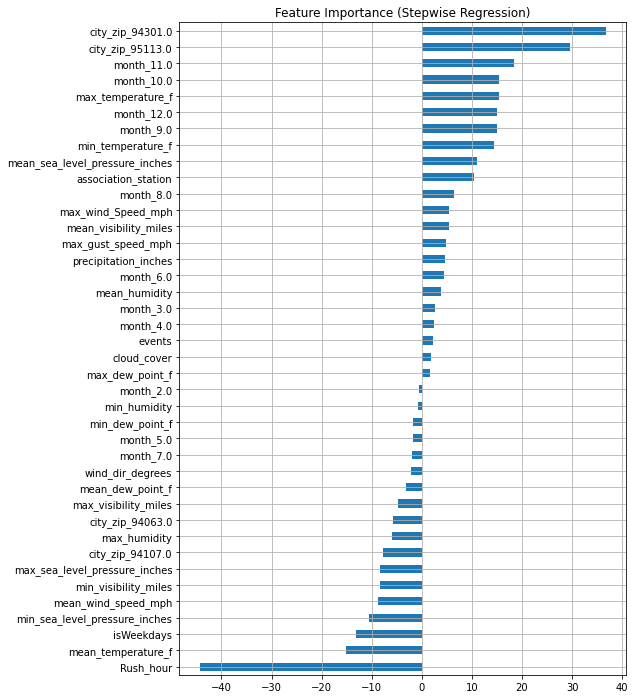

In [15]:
plt.figure(figsize=(8, 12))
coef = pd.Series(results.tvalues, index=X_train.columns)
coef = coef.sort_values()
coef.plot(kind='barh')
plt.grid()
plt.title('Feature Importance (Stepwise Regression)')
plt.show()

In [16]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=2.576, 
                       threshold_out =2.5, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on t-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its t-value > threshold_in
        threshold_out - exclude a feature if its t-value < threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in > threshold_out to avoid infinite looping.
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_tval = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_tval[new_column] = model.tvalues[new_column]
        print(f"df: {model.df_resid}")
        best_tval = abs(new_tval).max()
        if best_tval > threshold_in:
            best_feature_idx = abs(new_tval).argmax()
            best_feature = new_tval.index[best_feature_idx]
            x_i = X.columns.tolist().index(best_feature) + 1
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add x{:2} {:30} with t-value {:.6}'.format(x_i, best_feature, best_tval))
        
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        tvalues = model.tvalues.iloc[1:]
        worst_tval = abs(tvalues).min() # null if pvalues is empty
        if worst_tval < threshold_out:
            changed=True
            worst_feature_idx = abs(tvalues).argmin()
            worst_feature = included[worst_feature_idx]
            x_i = X.columns.tolist().index(worst_feature) + 1
            included.remove(worst_feature)
            if verbose:
                print('Drop x{:2} {:30} with t-value {:.6}'.format(x_i, worst_feature, worst_tval))
        if not changed:
            break
    return included

In [17]:
result = stepwise_selection(pd.DataFrame(X_train), list(y_train))
print(f"\nSelected features: {result}")

df: 1050541.0
Add x 5 city_zip_94107.0               with t-value 61.811
df: 1050540.0
Add x 2 Rush_hour                      with t-value 43.9538
df: 1050539.0
Add x 4 city_zip_94063.0               with t-value 33.5646
df: 1050538.0
Add x 6 city_zip_94301.0               with t-value 24.8641
df: 1050537.0
Add x 7 city_zip_95113.0               with t-value 25.5436
df: 1050536.0
Add x17 month_11.0                     with t-value 21.1929
df: 1050535.0
Add x18 month_12.0                     with t-value 23.4066
df: 1050534.0
Add x16 month_10.0                     with t-value 22.5483
df: 1050533.0
Add x15 month_9.0                      with t-value 21.9115
df: 1050532.0
Add x13 month_7.0                      with t-value 13.0878
df: 1050531.0
Add x 3 isWeekdays                     with t-value 12.8447
df: 1050530.0
Add x40 association_station            with t-value 11.7688
df: 1050529.0
Add x11 month_5.0                      with t-value 10.7661
df: 1050528.0
Add x25 max_humidity     

In [18]:
len(result)

33

In [19]:
set(X_train.columns).difference(set(result))

{'cloud_cover',
 'max_dew_point_f',
 'min_dew_point_f',
 'min_humidity',
 'month_3.0',
 'month_4.0',
 'wind_dir_degrees'}

In [20]:
results2 = sm.OLS(y_train, sm.add_constant(X_train[result])).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     bikes_available_percentage   R-squared:                       0.011
Model:                                    OLS   Adj. R-squared:                  0.011
Method:                         Least Squares   F-statistic:                     355.5
Date:                        Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                                18:54:36   Log-Likelihood:            -1.4848e+06
No. Observations:                     1050543   AIC:                         2.970e+06
Df Residuals:                         1050509   BIC:                         2.970e+06
Df Model:                                  33                                         
Covariance Type:                    nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.0083      0.004     -1.964      0.050      -0.017   -1.67e-05
city_zip_94107.0                  -0.0301      0.004     -7.918      0.000      -0.038      -0.023
Rush_hour                         -0.0994      0.002    -44.324      0.000      -0.104      -0.095
city_zip_94063.0                  -0.0285      0.005     -5.902      0.000      -0.038      -0.019
city_zip_94301.0                   0.2050      0.006     36.906      0.000       0.194       0.216
city_zip_95113.0                   0.1256      0.004     31.360      0.000       0.118       0.133
month_11.0                         0.0807      0.004     21.366      0.000       0.073       0.088
month_12.0                         0.0640      0.004     16.053      0.000       0.056       0.072
month_10.0                         0.0760      0.004     18.854      0.000       0.068       0.084
month_9.0                          0.0867      0.005     18.017      0.000       0.077       0.096
month_7.0                         -0.0328      0.006     -5.714      0.000      -0.044      -0.022
isWeekdays                        -0.0288      0.002    -13.247      0.000      -0.033      -0.025
association_station                0.0101      0.001     10.080      0.000       0.008       0.012
month_5.0                         -0.0239      0.004     -5.770      0.000      -0.032      -0.016
max_humidity                      -0.0159      0.002     -7.569      0.000      -0.020      -0.012
min_visibility_miles              -0.0168      0.002     -8.523      0.000      -0.021      -0.013
max_gust_speed_mph                 0.0065      0.001      5.020      0.000       0.004       0.009
mean_wind_speed_mph               -0.0169      0.002     -8.772      0.000      -0.021      -0.013
max_wind_Speed_mph                 0.0084      0.001      5.636      0.000       0.005       0.011
mean_humidity                      0.0186      0.004      4.996      0.000       0.011       0.026
month_8.0                          0.0321      0.006      5.628      0.000       0.021       0.043
max_temperature_f                  0.1494      0.009     15.732      0.000       0.131       0.168
mean_temperature_f                -0.2385      0.016    -15.125      0.000      -0.269      -0.208
min_temperature_f                  0.1300      0.009     14.840      0.000       0.113       0.147
mean_visibility_miles              0.0111      0.002      5.842      0.000       0.007       0.015
max_visibility_miles              -0.0068      0.001     -4.755      0.000      -0.010      -0.004
precipitation_inches               0.0059      0.001      5.095      0.000       0.004       0.008
mean_sea_level_pressure_i

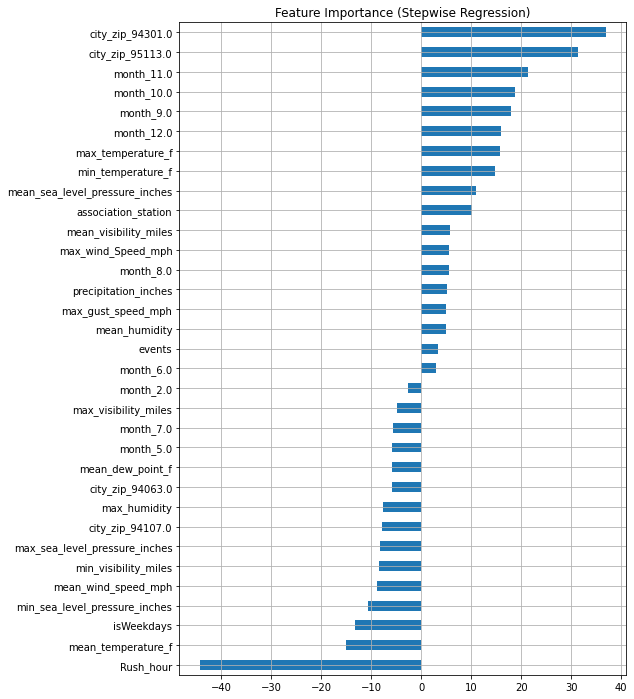

In [21]:
plt.figure(figsize=(8, 12))
coef2 = pd.Series(results2.tvalues, index=X_train[result].columns)
coef2 = coef2.sort_values()
coef2.plot(kind='barh')
plt.grid()
plt.title('Feature Importance (Stepwise Regression)')
plt.show()

# Models
* Non-sequential Methods
    * NN
    * Random Forest Regression
    * GBDT Regression
* Sequential Methods
    * LSTM
    
Performance metrics:
* MSE
* MAE
* MAPE

##### MAPE

In [24]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

### NN

In [25]:
list(set(X_train.columns).difference(set(result)))

['max_dew_point_f',
 'min_humidity',
 'cloud_cover',
 'month_4.0',
 'wind_dir_degrees',
 'min_dew_point_f',
 'month_3.0']

In [26]:
X_train_fs = X_train.drop(list(set(X_train.columns).difference(set(result))), axis=1)
X_test_fs = X_test.drop(list(set(X_train.columns).difference(set(result))), axis=1)

In [27]:
nn = Sequential([
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='linear'),
])
adam = optimizers.Adam(learning_rate=1e-04, epsilon=1e-07)

nn.compile(optimizer=adam,
          loss=losses.MeanSquaredError(),
          metrics=['mape', 'mae']
          )

In [28]:
start = time.time()
nn.fit(np.array(X_train_fs), np.array(y_train), batch_size=512, validation_split=0.2, epochs=10)
end = time.time()
print(f"training time: {end-start} sec.")

Epoch 1/10
1642/1642 [==============================] - 11s 7ms/step - loss: 0.9077 - mape: 134.0781 - mae: 0.7521 - val_loss: 1.3306 - val_mape: 138.0347 - val_mae: 0.9352
Epoch 2/10
1642/1642 [==============================] - 11s 7ms/step - loss: 0.8953 - mape: 152.3289 - mae: 0.7451 - val_loss: 1.3443 - val_mape: 146.1733 - val_mae: 0.9390
Epoch 3/10
1642/1642 [==============================] - 11s 7ms/step - loss: 0.8889 - mape: 158.5493 - mae: 0.7415 - val_loss: 1.3532 - val_mape: 155.1503 - val_mae: 0.9410
Epoch 4/10
1642/1642 [==============================] - 11s 7ms/step - loss: 0.8856 - mape: 159.0884 - mae: 0.7391 - val_loss: 1.3417 - val_mape: 144.1113 - val_mae: 0.9394
Epoch 5/10
1642/1642 [==============================] - 11s 7ms/step - loss: 0.8812 - mape: 161.1569 - mae: 0.7368 - val_loss: 1.3511 - val_mape: 148.8666 - val_mae: 0.9409
Epoch 6/10
1642/1642 [==============================] - 11s 7ms/step - loss: 0.8848 - mape: 161.3468 - mae: 0.7381 - val_loss: 1.3556 -

In [29]:
nn.evaluate(np.array(X_test_fs), np.array(y_test))
y_pred = nn.predict(np.array(X_test_fs))

4820/4820 [==============================] - 3s 559us/step - loss: 1.1381 - mape: 128.9243 - mae: 0.8696


In [36]:
mape(y_stdscaler.inverse_transform(y_pred).reshape(-1), y_stdscaler.inverse_transform(y_test))

34.91641437708396

In [37]:
mean_absolute_error(y_stdscaler.inverse_transform(y_pred).reshape(-1), y_stdscaler.inverse_transform(y_test))

0.163316814613565

In [38]:
mean_squared_error(y_stdscaler.inverse_transform(y_pred).reshape(-1), y_stdscaler.inverse_transform(y_test))

0.040145021755549744

### RandomForestRegressor

In [39]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 20, random_state = 42)
# Train the model on training data
rf.fit(np.array(X_train_fs), np.array(y_train))

RandomForestRegressor(n_estimators=20, random_state=42)

In [40]:
# Use the forest's predict method on the test data
y_pred_rf = rf.predict(np.array(X_test_fs))
# Calculate the absolute errors
errors = abs(y_pred_rf - np.array(y_test))
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.87 degrees.


In [41]:
print("mae: ", mean_absolute_error(y_stdscaler.inverse_transform(y_pred_rf).reshape(-1), y_stdscaler.inverse_transform(y_test)))
print("mse: ", mean_squared_error(y_stdscaler.inverse_transform(y_pred_rf).reshape(-1), y_stdscaler.inverse_transform(y_test)))
print("mape: ", mape(y_stdscaler.inverse_transform(y_pred_rf).reshape(-1), y_stdscaler.inverse_transform(y_test)))

mae:  0.1633202312735889
mse:  0.040199077880187006
mape:  35.01821053001727


### GradientBoostingRegressor

In [42]:
gbr = GradientBoostingRegressor(
    max_depth=7,
    n_estimators=60,
    learning_rate=0.1
)
gbr.fit(np.array(X_train_fs), np.array(y_train))

GradientBoostingRegressor(max_depth=7, n_estimators=60)

In [43]:
# Use the forest's predict method on the test data
y_pred_gbr = gbr.predict(np.array(X_test_fs))
# Calculate the absolute errors
errors = abs(y_pred_gbr - np.array(y_test))
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.87 degrees.


In [44]:
print("mae: ", mean_absolute_error(y_stdscaler.inverse_transform(y_pred_gbr).reshape(-1), y_stdscaler.inverse_transform(y_test)))
print("mse: ", mean_squared_error(y_stdscaler.inverse_transform(y_pred_gbr).reshape(-1), y_stdscaler.inverse_transform(y_test)))
print("mape: ", mape(y_stdscaler.inverse_transform(y_pred_gbr).reshape(-1), y_stdscaler.inverse_transform(y_test)))

mae:  0.16297948456766123
mse:  0.03996059127648984
mape:  34.91978221343243


### LSTM

In [45]:
def buildTrain(train, pastWeek=4, futureWeek=1):
    X_train, y_train = [], []
    for i in range(train.shape[0]-futureWeek-pastWeek):
        X_train.append(np.array(train.iloc[i:i+pastWeek, :]))
        y_train.append(np.array(train.iloc[i+pastWeek:i+pastWeek+futureWeek]['bikes_available_percentage']))
    return X_train, y_train

In [70]:
def buildManyToOneModel(shape):
    model = Sequential()
    model.add(layers.LSTM(100, input_length=shape[1], input_dim=shape[2]))
    model.add(layers.Dense(64))
    model.add(layers.Dense(32))
    model.add(layers.Dense(16))
    model.add(layers.Dense(8))
    model.add(layers.Dense(4))
    model.add(layers.Dense(1))
    model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape'])
#     model.summary()
    return model

# def buildManyToOneModel(shape):
#     model = Sequential()
#     model.add(layers.LSTM(128, input_length=shape[1], input_dim=shape[2]))
#     model.add(layers.Dropout(0.3))
#     model.add(layers.Dense(64))
#     model.add(layers.Dropout(0.3))
#     model.add(layers.Dense(32))
#     model.add(layers.Dense(16))
#     model.add(layers.Dense(8))
#     model.add(layers.Dense(4))
#     model.add(layers.Dense(1))
    
#     adam = keras.optimizers.Adam(learning_rate=0.0001)
#     model.compile(loss="mse", optimizer=adam, metrics=['mae', 'mape'])
# #     model.summary()
#     return model

##### Seq training data

In [47]:
dropcol = ['time', 'year', 'month', 'hour', 'station_id',
           'bikes_available', 'docks_available', 'dock_count',
           'cloud_cover', 'min_dew_point_f', 'month_3.0', 'max_dew_point_f',
           'month_4.0', 'min_humidity', 'wind_dir_degrees']

In [48]:
X_train_seq, y_train_seq = [], []
for i in train.station_id.unique():
    train_i = train.loc[train['station_id']==i, :].drop(dropcol, axis=1).reset_index().drop("index", axis=1)
    Xi_seq, yi_seq = buildTrain(train_i)
    X_train_seq = X_train_seq+Xi_seq
    y_train_seq = y_train_seq+yi_seq
print("done.")

done.


In [49]:
X_train_seq = np.array(X_train_seq)
X_train_seq.shape # n 4 33

(1050193, 4, 34)

In [50]:
y_train_seq = np.array(y_train_seq)
y_train_seq.shape

(1050193, 1)

##### Seq testing data

In [51]:
X_test_seq, y_test_seq = [], []
for i in test.station_id.unique():
    test_i = test.loc[test['station_id']==i, :].drop(dropcol, axis=1).reset_index().drop("index", axis=1)
    Xi_seq, yi_seq = buildTrain(test_i)
    X_test_seq = X_test_seq+Xi_seq
    y_test_seq = y_test_seq+yi_seq
print("done.")

done.


In [52]:
X_test_seq = np.array(X_test_seq)
X_test_seq.shape

(153871, 4, 34)

In [53]:
y_test_seq = np.array(y_test_seq)
y_test_seq.shape

(153871, 1)

##### Training and Evaluation

In [71]:
model = buildManyToOneModel(X_train_seq.shape)
model.fit(X_train_seq, y_train_seq, batch_size=512, validation_split=0.2, epochs=10)

Epoch 1/10
1641/1641 [==============================] - 66s 39ms/step - loss: 0.1457 - mae: 0.2159 - mape: 110.3600 - val_loss: 0.1869 - val_mae: 0.2522 - val_mape: 127.5808
Epoch 2/10
1641/1641 [==============================] - 62s 38ms/step - loss: 0.1040 - mae: 0.1715 - mape: 91.1653 - val_loss: 0.1808 - val_mae: 0.2595 - val_mape: 118.2130
Epoch 3/10
1641/1641 [==============================] - 62s 38ms/step - loss: 0.0997 - mae: 0.1656 - mape: 92.0138 - val_loss: 0.1738 - val_mae: 0.2383 - val_mape: 121.7080
Epoch 4/10
1641/1641 [==============================] - 62s 38ms/step - loss: 0.0988 - mae: 0.1629 - mape: 89.9560 - val_loss: 0.1734 - val_mae: 0.2362 - val_mape: 122.9114
Epoch 5/10
1641/1641 [==============================] - 62s 38ms/step - loss: 0.0990 - mae: 0.1628 - mape: 89.6119 - val_loss: 0.1728 - val_mae: 0.2441 - val_mape: 116.8916
Epoch 6/10
1641/1641 [==============================] - 62s 38ms/step - loss: 0.0970 - mae: 0.1610 - mape: 87.0228 - val_loss: 0.1713 

In [72]:
model.evaluate(X_test_seq, y_test_seq)
y_pred_lstm = model.predict(X_test_seq)

4809/4809 [==============================] - 13s 3ms/step - loss: 0.1308 - mae: 0.1975 - mape: 89.6463


In [73]:
y_test_seq.shape

(153871, 1)

In [74]:
print("mae: ", mean_absolute_error(y_stdscaler.inverse_transform(y_pred_lstm).reshape(-1), y_stdscaler.inverse_transform(y_test_seq).reshape(-1)))
print("mse: ", mean_squared_error(y_stdscaler.inverse_transform(y_pred_lstm).reshape(-1), y_stdscaler.inverse_transform(y_test_seq).reshape(-1)))
print("mape: ", mape(y_stdscaler.inverse_transform(y_pred_lstm).reshape(-1), y_stdscaler.inverse_transform(y_test_seq).reshape(-1)))

mae:  0.03708659296088714
mse:  0.00461309805308869
mape:  10.496345760873407


In [ ]:
# mae:  0.03543539765464366
# mse:  0.004563085905336709
# mape:  10.335720111891893

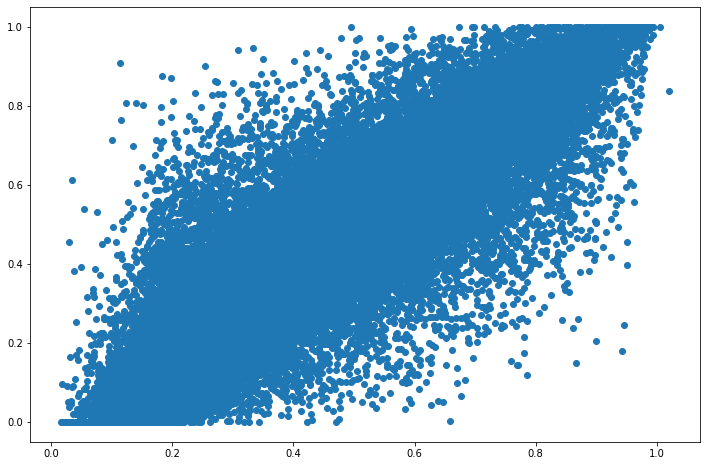

In [104]:
plt.figure(figsize=(12, 8))
plt.scatter(y_stdscaler.inverse_transform(y_pred_lstm).reshape(-1), y_stdscaler.inverse_transform(y_test_seq).reshape(-1))
plt.show()

### ANN

In [99]:
def build_ann_model():
    model = Sequential([
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='linear'),
    ])
    adam = optimizers.Adam(learning_rate=1e-04, epsilon=1e-07)
    model.compile(optimizer=adam,
              loss=losses.MeanSquaredError(),
              metrics=['mae', 'mape']
    )
    return model

In [93]:
X_train_seq.reshape(-1, 4*34).shape

(1050193, 136)

In [98]:
y_train_seq.reshape(-1).shape

(1050193,)

In [100]:
ann = build_ann_model()
start = time.time()
ann.fit(X_train_seq.reshape(-1, 4*34), y_train_seq.reshape(-1), batch_size=512, validation_split=0.2, epochs=10)
end = time.time()
print(f"training time: {end-start} sec.")

Epoch 1/10
1641/1641 [==============================] - 45s 27ms/step - loss: 0.1954 - mae: 0.2601 - val_loss: 0.1848 - val_mae: 0.2564
Epoch 2/10
1641/1641 [==============================] - 44s 27ms/step - loss: 0.1044 - mae: 0.1793 - val_loss: 0.1819 - val_mae: 0.2580
Epoch 3/10
1641/1641 [==============================] - 44s 27ms/step - loss: 0.1025 - mae: 0.1744 - val_loss: 0.1773 - val_mae: 0.2494
Epoch 4/10
1641/1641 [==============================] - 44s 27ms/step - loss: 0.0998 - mae: 0.1709 - val_loss: 0.1792 - val_mae: 0.2584
Epoch 5/10
1641/1641 [==============================] - 44s 27ms/step - loss: 0.0984 - mae: 0.1689 - val_loss: 0.1756 - val_mae: 0.2496
Epoch 6/10
1641/1641 [==============================] - 43s 27ms/step - loss: 0.0980 - mae: 0.1676 - val_loss: 0.1744 - val_mae: 0.2487
Epoch 7/10
1641/1641 [==============================] - 44s 27ms/step - loss: 0.0970 - mae: 0.1661 - val_loss: 0.1745 - val_mae: 0.2493
Epoch 8/10
1641/1641 [==========================

In [101]:
ann.evaluate(X_test_seq.reshape(-1, 4*34), y_test_seq.reshape(-1))
y_pred_ann = ann.predict(X_test_seq.reshape(-1, 4*34))

4809/4809 [==============================] - 9s 2ms/step - loss: 0.1308 - mae: 0.1954


In [102]:
print("mae: ", mean_absolute_error(y_stdscaler.inverse_transform(y_pred_ann).reshape(-1), y_stdscaler.inverse_transform(y_test_seq.reshape(-1))))
print("mse: ", mean_squared_error(y_stdscaler.inverse_transform(y_pred_ann).reshape(-1), y_stdscaler.inverse_transform(y_test_seq.reshape(-1))))
print("mape: ", mape(y_stdscaler.inverse_transform(y_pred_ann).reshape(-1), y_stdscaler.inverse_transform(y_test_seq.reshape(-1))))

mae:  0.036704310320133056
mse:  0.004613291152610216
mape:  10.569750756174194


# Time Series Split Cross Validation 

### Generate Date for LSTM

In [63]:
time_scale = train.loc[train['station_id']==2, :].time.unique()
tscv_idx = TimeSeriesSplit(n_splits = 10).split(time_scale)
tscv_folds_X_train, tscv_folds_y_train = dict(), dict()
tscv_folds_X_val, tscv_folds_y_val = dict(), dict()
for f, (train_idx, val_idx) in enumerate(tscv_idx):
    print("----\nfold ", f)
    tscv_folds_X_train[f], tscv_folds_y_train[f] = [], []
    tscv_folds_X_val[f], tscv_folds_y_val[f] = [], []
    
    for i in train.station_id.unique():
        # train cv
        tmask_train = train.loc[train['station_id']==i, 'time'].isin(time_scale[train_idx])
        train_i = train.loc[train['station_id']==i, :].loc[tmask_train, :].drop(dropcol, axis=1).reset_index().drop("index", axis=1)
        Xi_seq, yi_seq = buildTrain(train_i)
        tscv_folds_X_train[f] = tscv_folds_X_train[f]+Xi_seq
        tscv_folds_y_train[f] = tscv_folds_y_train[f]+yi_seq
        # test cv
        tmask_val = train.loc[train['station_id']==i, 'time'].isin(time_scale[val_idx])
        train_i = train.loc[train['station_id']==i, :].loc[tmask_val, :].drop(dropcol, axis=1).reset_index().drop("index", axis=1)
        Xi_seq, yi_seq = buildTrain(train_i)
        tscv_folds_X_val[f] = tscv_folds_X_val[f]+Xi_seq
        tscv_folds_y_val[f] = tscv_folds_y_val[f]+yi_seq
print("done.")

----
fold  0
----
fold  1
----
fold  2
----
fold  3
----
fold  4
----
fold  5
----
fold  6
----
fold  7
----
fold  8
----
fold  9
done.


In [64]:
time_scale[train_idx]

array(['2013/08/29', '2013/08/30', '2013/08/31', '2013/09/01',
       '2013/09/02', '2013/09/03', '2013/09/04', '2013/09/05',
       '2013/09/06', '2013/09/07', '2013/09/08', '2013/09/09',
       '2013/09/10', '2013/09/11', '2013/09/12', '2013/09/13',
       '2013/09/14', '2013/09/15', '2013/09/16', '2013/09/17',
       '2013/09/18', '2013/09/19', '2013/09/20', '2013/09/21',
       '2013/09/22', '2013/09/23', '2013/09/24', '2013/09/25',
       '2013/09/26', '2013/09/27', '2013/09/28', '2013/09/29',
       '2013/09/30', '2013/10/01', '2013/10/02', '2013/10/03',
       '2013/10/04', '2013/10/05', '2013/10/06', '2013/10/07',
       '2013/10/08', '2013/10/09', '2013/10/10', '2013/10/11',
       '2013/10/12', '2013/10/13', '2013/10/14', '2013/10/15',
       '2013/10/16', '2013/10/17', '2013/10/18', '2013/10/19',
       '2013/10/20', '2013/10/21', '2013/10/22', '2013/10/23',
       '2013/10/24', '2013/10/25', '2013/10/26', '2013/10/27',
       '2013/10/28', '2013/10/29', '2013/10/30', '2013/

### LSTM (tscv)

In [75]:
mse_lstm = []
mae_lstm = []
mape_lstm = []
preds = []

for f in tscv_folds_X_train:
    print(f"=====\nfold {f+1}")
    X_train_cv, y_train_cv = np.array(tscv_folds_X_train[f]), np.array(tscv_folds_y_train[f])
    X_valid_cv, y_valid_cv = np.array(tscv_folds_X_val[f]), np.array(tscv_folds_y_val[f])
    
    model = buildManyToOneModel(X_train_cv.shape)
#     callback = EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="auto")
    model.fit(X_train_cv, y_train_cv, batch_size=512, validation_split=0.2, epochs=10, verbose=2)
    
    scores_cv = model.evaluate(np.array(X_valid_cv), np.array(y_valid_cv))
    y_pred_cv = model.predict(X_valid_cv)
    
    mse_lstm.append(mean_squared_error(y_stdscaler.inverse_transform(y_pred_cv).reshape(-1), y_stdscaler.inverse_transform(y_valid_cv).reshape(-1)))
    mae_lstm.append(mean_absolute_error(y_stdscaler.inverse_transform(y_pred_cv).reshape(-1), y_stdscaler.inverse_transform(y_valid_cv).reshape(-1)))
    mape_lstm.append(mape(y_stdscaler.inverse_transform(y_pred_cv).reshape(-1), y_stdscaler.inverse_transform(y_valid_cv).reshape(-1)))
    
print()
print("MSE: %0.4f (+/- %0.4f)" % (np.mean(mse_lstm), np.std(mse_lstm) * 1.96))
print("MAE: %0.4f (+/- %0.4f)" % (np.mean(mae_lstm), np.std(mae_lstm) * 1.96))
print("MAPE: %0.4f (+/- %0.4f)" % (np.mean(mape_lstm), np.std(mape_lstm) * 1.96))

=====
fold 1
Epoch 1/10
145/145 - 7s - loss: 0.1740 - mae: 0.2547 - mape: 157.0941 - val_loss: 0.2234 - val_mae: 0.3021 - val_mape: 165.4681
Epoch 2/10
145/145 - 5s - loss: 0.1099 - mae: 0.1896 - mape: 114.7475 - val_loss: 0.2061 - val_mae: 0.2973 - val_mape: 145.2436
Epoch 3/10
145/145 - 5s - loss: 0.1047 - mae: 0.1805 - mape: 110.0377 - val_loss: 0.2058 - val_mae: 0.2978 - val_mape: 151.8590
Epoch 4/10
145/145 - 5s - loss: 0.1040 - mae: 0.1802 - mape: 108.3410 - val_loss: 0.2038 - val_mae: 0.2817 - val_mape: 153.6369
Epoch 5/10
145/145 - 5s - loss: 0.1035 - mae: 0.1792 - mape: 108.4920 - val_loss: 0.2035 - val_mae: 0.2824 - val_mape: 153.9185
Epoch 6/10
145/145 - 5s - loss: 0.1026 - mae: 0.1761 - mape: 105.8919 - val_loss: 0.2016 - val_mae: 0.2801 - val_mape: 152.5042
Epoch 7/10
145/145 - 5s - loss: 0.1022 - mae: 0.1761 - mape: 106.1042 - val_loss: 0.2026 - val_mae: 0.2886 - val_mape: 150.2220
Epoch 8/10
145/145 - 5s - loss: 0.1013 - mae: 0.1732 - mape: 103.2720 - val_loss: 0.2015 - 

3000/3000 [==============================] - 6s 2ms/step - loss: 0.1355 - mae: 0.1954 - mape: 93.8083
=====
fold 7
Epoch 1/10
1033/1033 - 35s - loss: 0.1204 - mae: 0.1922 - mape: 108.0132 - val_loss: 0.1790 - val_mae: 0.2570 - val_mape: 125.2688
Epoch 2/10
1033/1033 - 33s - loss: 0.1040 - mae: 0.1725 - mape: 97.7303 - val_loss: 0.1740 - val_mae: 0.2476 - val_mape: 128.1996
Epoch 3/10
1033/1033 - 33s - loss: 0.1016 - mae: 0.1685 - mape: 96.3099 - val_loss: 0.1738 - val_mae: 0.2563 - val_mape: 124.6238
Epoch 4/10
1033/1033 - 33s - loss: 0.1001 - mae: 0.1664 - mape: 95.5441 - val_loss: 0.1686 - val_mae: 0.2429 - val_mape: 126.0953
Epoch 5/10
1033/1033 - 33s - loss: 0.0992 - mae: 0.1648 - mape: 95.3472 - val_loss: 0.1678 - val_mae: 0.2357 - val_mape: 130.1308
Epoch 6/10
1033/1033 - 33s - loss: 0.0986 - mae: 0.1641 - mape: 94.7127 - val_loss: 0.1668 - val_mae: 0.2362 - val_mape: 129.8295
Epoch 7/10
1033/1033 - 33s - loss: 0.0980 - mae: 0.1638 - mape: 94.3654 - val_loss: 0.1673 - val_mae: 0.

### Generate Data for Non-sequential models

In [76]:
time_scale = train.loc[train['station_id']==2, :].time.unique()
tscv_idx = TimeSeriesSplit(n_splits = 10).split(time_scale)
kcv_folds_X_train, kcv_folds_y_train = dict(), dict()
kcv_folds_X_val, kcv_folds_y_val = dict(), dict()
for f, (train_idx, val_idx) in enumerate(tscv_idx):
    print("----\nfold ", f)
    kcv_folds_X_train[f], kcv_folds_y_train[f] = pd.DataFrame(), pd.Series(dtype='float64')
    kcv_folds_X_val[f], kcv_folds_y_val[f] = pd.DataFrame(), pd.Series(dtype='float64')
    
    for i in train.station_id.unique():
        # train cv
        tmask_train = train.loc[train['station_id']==i, 'time'].isin(time_scale[train_idx])
        train_i = train.loc[train['station_id']==i, :].loc[tmask_train, :].drop(dropcol, axis=1).reset_index().drop("index", axis=1)
        kcv_folds_X_train[f] = kcv_folds_X_train[f].append(train_i.iloc[:, :-1])
        kcv_folds_y_train[f] = kcv_folds_y_train[f].append(train_i.iloc[:, -1])
        # test cv
        tmask_val = train.loc[train['station_id']==i, 'time'].isin(time_scale[val_idx])
        train_i = train.loc[train['station_id']==i, :].loc[tmask_val, :].drop(dropcol, axis=1).reset_index().drop("index", axis=1)
        kcv_folds_X_val[f] = kcv_folds_X_val[f].append(train_i.iloc[:, :-1])
        kcv_folds_y_val[f] = kcv_folds_y_val[f].append(train_i.iloc[:, -1])
print("done.")

----
fold  0
----
fold  1
----
fold  2
----
fold  3
----
fold  4
----
fold  5
----
fold  6
----
fold  7
----
fold  8
----
fold  9
done.


### GBDT (tscv)

In [77]:
# GBDT
mse_gbdt = []
mae_gbdt = []
mape_gbdt = []
preds = []

for f in kcv_folds_X_train:
    print(f"=====\nfold {f+1}")
    X_train_cv, y_train_cv = np.array(kcv_folds_X_train[f]), np.array(kcv_folds_y_train[f])
    X_valid_cv, y_valid_cv = np.array(kcv_folds_X_val[f]), np.array(kcv_folds_y_val[f])
    
    gbr = GradientBoostingRegressor(
        max_depth=7,
        n_estimators=60,
        learning_rate=0.1
    )
    gbr.fit(np.array(X_train_cv), np.array(y_train_cv))
    y_pred_cv = gbr.predict(np.array(X_valid_cv))
    
    mae_gbdt.append(mean_absolute_error(y_stdscaler.inverse_transform(y_pred_cv).reshape(-1), y_stdscaler.inverse_transform(y_valid_cv)))
    mse_gbdt.append(mean_squared_error(y_stdscaler.inverse_transform(y_pred_cv).reshape(-1), y_stdscaler.inverse_transform(y_valid_cv)))
    mape_gbdt.append(mape(y_stdscaler.inverse_transform(y_pred_cv).reshape(-1), y_stdscaler.inverse_transform(y_valid_cv)))

print()
print("MSE: %0.4f (+/- %0.4f)" % (np.mean(mse_gbdt), np.std(mse_gbdt) * 1.96))
print("MAE: %0.4f (+/- %0.4f)" % (np.mean(mae_gbdt), np.std(mae_gbdt) * 1.96))
print("MAPE: %0.4f (+/- %0.4f)" % (np.mean(mape_gbdt), np.std(mape_gbdt) * 1.96))

=====
fold 1
=====
fold 2
=====
fold 3
=====
fold 4
=====
fold 5
=====
fold 6
=====
fold 7
=====
fold 8
=====
fold 9
=====
fold 10

MSE: 0.0356 (+/- 0.0131)
MAE: 0.1498 (+/- 0.0365)
MAPE: 31.1285 (+/- 7.4331)


### Random Forest Regressor (tscv)

In [78]:
# RFR
mse_rfr = []
mae_rfr = []
mape_rfr = []
preds = []

for f in kcv_folds_X_train:
    print(f"=====\nfold {f+1}")
    X_train_cv, y_train_cv = np.array(kcv_folds_X_train[f]), np.array(kcv_folds_y_train[f])
    X_valid_cv, y_valid_cv = np.array(kcv_folds_X_val[f]), np.array(kcv_folds_y_val[f])
    
    rf = RandomForestRegressor(n_estimators = 20, random_state = 42)
    rf.fit(np.array(X_train_cv), np.array(y_train_cv))
    y_pred_cv = rf.predict(np.array(X_valid_cv))
    
    mae_rfr.append(mean_absolute_error(y_stdscaler.inverse_transform(y_pred_cv).reshape(-1), y_stdscaler.inverse_transform(y_valid_cv)))
    mse_rfr.append(mean_squared_error(y_stdscaler.inverse_transform(y_pred_cv).reshape(-1), y_stdscaler.inverse_transform(y_valid_cv)))
    mape_rfr.append(mape(y_stdscaler.inverse_transform(y_pred_cv).reshape(-1), y_stdscaler.inverse_transform(y_valid_cv)))
    

print()
print("MSE: %0.4f (+/- %0.4f)" % (np.mean(mse_rfr), np.std(mse_rfr) * 1.96))
print("MAE: %0.4f (+/- %0.4f)" % (np.mean(mae_rfr), np.std(mae_rfr) * 1.96))
print("MAPE: %0.4f (+/- %0.4f)" % (np.mean(mape_rfr), np.std(mape_rfr) * 1.96))

=====
fold 1
=====
fold 2
=====
fold 3
=====
fold 4
=====
fold 5
=====
fold 6
=====
fold 7
=====
fold 8
=====
fold 9
=====
fold 10

MSE: 0.0358 (+/- 0.0133)
MAE: 0.1503 (+/- 0.0366)
MAPE: 31.3556 (+/- 7.4505)


### NN (tscv)

In [79]:
# Build model
def build_model():
    model = Sequential([
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='linear'),
    ])
    adam = optimizers.Adam(learning_rate=1e-04, epsilon=1e-07)
    model.compile(optimizer=adam,
              loss=losses.MeanSquaredError(),
              metrics=['mae']
    )
    return model

In [80]:
# NN
mse_nn = []
mae_nn = []
mape_nn = []
preds = []

for f in kcv_folds_X_train:
    print(f"=====\nfold {f+1}")
    X_train_cv, y_train_cv = np.array(kcv_folds_X_train[f]), np.array(kcv_folds_y_train[f])
    X_valid_cv, y_valid_cv = np.array(kcv_folds_X_val[f]), np.array(kcv_folds_y_val[f])
    
    
    model = build_model()
    model.fit(np.array(X_train_cv), np.array(y_train_cv), batch_size=512, validation_split=0.2, epochs=10, verbose=2)
    
    scores_cv = model.evaluate(np.array(X_valid_cv), np.array(y_valid_cv))
    y_pred_cv = model.predict(np.array(X_valid_cv))
    
    mae_nn.append(mean_absolute_error(y_stdscaler.inverse_transform(y_pred_cv).reshape(-1), y_stdscaler.inverse_transform(y_valid_cv)))
    mse_nn.append(mean_squared_error(y_stdscaler.inverse_transform(y_pred_cv).reshape(-1), y_stdscaler.inverse_transform(y_valid_cv)))
    mape_nn.append(mape(y_stdscaler.inverse_transform(y_pred_cv).reshape(-1), y_stdscaler.inverse_transform(y_valid_cv)))

print()
print("MSE: %0.4f (+/- %0.4f)" % (np.mean(mse_nn), np.std(mse_nn) * 1.96))
print("MAE: %0.4f (+/- %0.4f)" % (np.mean(mae_nn), np.std(mae_nn) * 1.96))
print("MAPE: %0.4f (+/- %0.4f)" % (np.mean(mape_nn), np.std(mape_nn) * 1.96))

=====
fold 1
Epoch 1/10
146/146 - 4s - loss: 0.7791 - mae: 0.6864 - val_loss: 1.3737 - val_mae: 0.9614
Epoch 2/10
146/146 - 3s - loss: 0.7641 - mae: 0.6770 - val_loss: 1.3872 - val_mae: 0.9661
Epoch 3/10
146/146 - 3s - loss: 0.7607 - mae: 0.6753 - val_loss: 1.3926 - val_mae: 0.9669
Epoch 4/10
146/146 - 3s - loss: 0.7596 - mae: 0.6746 - val_loss: 1.4035 - val_mae: 0.9709
Epoch 5/10
146/146 - 3s - loss: 0.7576 - mae: 0.6738 - val_loss: 1.4223 - val_mae: 0.9747
Epoch 6/10
146/146 - 3s - loss: 0.7573 - mae: 0.6733 - val_loss: 1.4091 - val_mae: 0.9719
Epoch 7/10
146/146 - 3s - loss: 0.7564 - mae: 0.6730 - val_loss: 1.3931 - val_mae: 0.9681
Epoch 8/10
146/146 - 4s - loss: 0.7552 - mae: 0.6729 - val_loss: 1.4134 - val_mae: 0.9739
Epoch 9/10
146/146 - 3s - loss: 0.7550 - mae: 0.6726 - val_loss: 1.4120 - val_mae: 0.9732
Epoch 10/10
146/146 - 3s - loss: 0.7544 - mae: 0.6721 - val_loss: 1.4183 - val_mae: 0.9746
2784/2784 [==============================] - 5s 2ms/step - loss: 0.8099 - mae: 0.7001


Epoch 2/10
1338/1338 - 31s - loss: 0.8435 - mae: 0.7158 - val_loss: 1.2841 - val_mae: 0.9138
Epoch 3/10
1338/1338 - 31s - loss: 0.8401 - mae: 0.7138 - val_loss: 1.2838 - val_mae: 0.9144
Epoch 4/10
1338/1338 - 31s - loss: 0.8379 - mae: 0.7125 - val_loss: 1.2871 - val_mae: 0.9155
Epoch 5/10
1338/1338 - 30s - loss: 0.8363 - mae: 0.7116 - val_loss: 1.2833 - val_mae: 0.9144
Epoch 6/10
1338/1338 - 31s - loss: 0.8352 - mae: 0.7109 - val_loss: 1.2889 - val_mae: 0.9166
Epoch 7/10
1338/1338 - 30s - loss: 0.8343 - mae: 0.7104 - val_loss: 1.2909 - val_mae: 0.9171
Epoch 8/10
1338/1338 - 31s - loss: 0.8337 - mae: 0.7100 - val_loss: 1.2866 - val_mae: 0.9165
Epoch 9/10
1338/1338 - 30s - loss: 0.8331 - mae: 0.7097 - val_loss: 1.2996 - val_mae: 0.9192
Epoch 10/10
1338/1338 - 30s - loss: 0.8325 - mae: 0.7095 - val_loss: 1.2982 - val_mae: 0.9185
3043/3043 [==============================] - 5s 2ms/step - loss: 1.2872 - mae: 0.9372
=====
fold 10
Epoch 1/10
1490/1490 - 34s - loss: 0.8806 - mae: 0.7363 - val_

### tscv Result Visualization

In [81]:
performance_mse = pd.DataFrame({
    'GBDT': mse_gbdt,
    'RFR': mse_rfr,
    'NN': mse_nn,
    'LSTM': mse_lstm
})
performance_mae = pd.DataFrame({
    'GBDT': mae_gbdt,
    'RFR': mae_rfr,
    'NN': mae_nn,
    'LSTM': mae_lstm
})
performance_mape = pd.DataFrame({
    'GBDT': mape_gbdt,
    'RFR': mape_rfr,
    'NN': mape_nn,
    'LSTM': mape_lstm
})

In [82]:
performance_mse

,GBDT,RFR,NN,LSTM
0,0.027816,0.027872,0.028567,0.004456
1,0.025467,0.025559,0.025607,0.003597
2,0.027794,0.028112,0.027869,0.003856
3,0.032330,0.032421,0.032654,0.004236
4,0.034026,0.034183,0.034147,0.004474
5,0.039327,0.040027,0.039773,0.004779
6,0.041400,0.041628,0.041510,0.004265
7,0.039113,0.039461,0.039370,0.003533
8,0.044692,0.045124,0.045404,0.004355
9,0.043683,0.044107,0.044302,0.004192


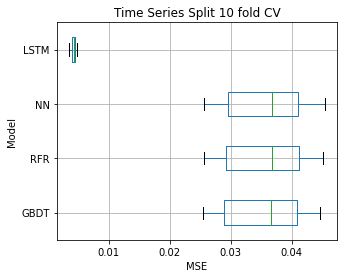

In [83]:
performance_mse.boxplot(vert=False)
plt.subplots_adjust(left=0.25)
plt.title("Time Series Split 10 fold CV")
plt.xlabel("MSE")
plt.ylabel("Model")
plt.show()

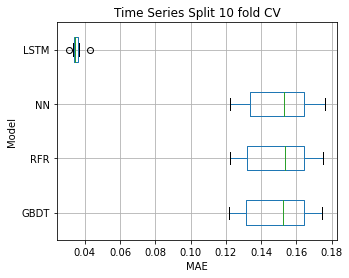

In [84]:
performance_mae.boxplot(vert=False)
plt.subplots_adjust(left=0.25)
plt.title("Time Series Split 10 fold CV")
plt.xlabel("MAE")
plt.ylabel("Model")
plt.show()

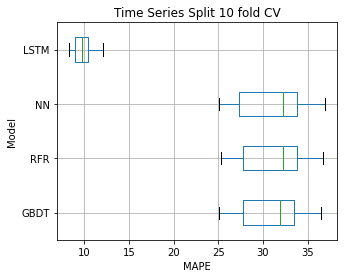

In [85]:
performance_mape.boxplot(vert=False)
plt.subplots_adjust(left=0.25)
plt.title("Time Series Split 10 fold CV")
plt.xlabel("MAPE")
plt.ylabel("Model")
plt.show()

<AxesSubplot:>

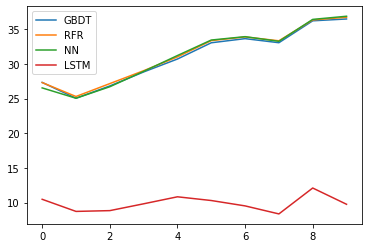

In [87]:
performance_mape.plot()

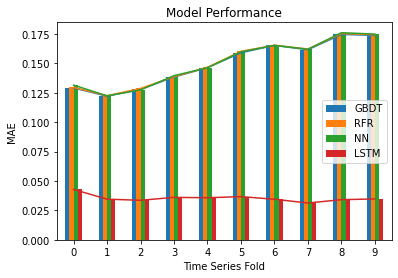

In [88]:
performance_mae.plot.bar()
plt.plot(performance_mae)
plt.title("Model Performance")
plt.xlabel("Time Series Fold")
plt.ylabel("MAE")
plt.xticks(rotation=0)
plt.show()

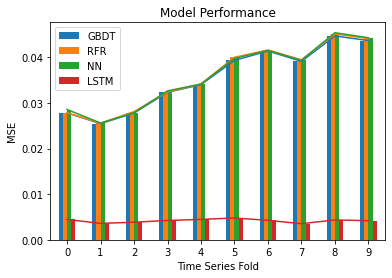

In [89]:
performance_mse.plot.bar()
plt.plot(performance_mse)
plt.title("Model Performance")
plt.xlabel("Time Series Fold")
plt.ylabel("MSE")
plt.xticks(rotation=0)
plt.show()

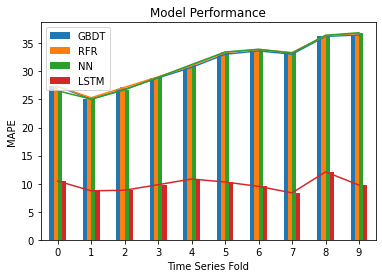

In [91]:
performance_mape.plot.bar()
plt.plot(performance_mape)
plt.title("Model Performance")
plt.xlabel("Time Series Fold")
plt.ylabel("MAPE")
plt.xticks(rotation=0)
plt.show()